This notebooks address the **fashion-MNIST** dataset using convolutional neural networks and commonly used techniques for addressing overfit.

The best performance is achieved using the architecture proposed by Olivia Nocentini et al. (2022), which uses 15 convolutional layers. The results can still be exploited further.

--
#### Package imports
Imports all the libraries used in the notebook

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
matplotlib.rc('axes',edgecolor='gray')
import matplotlib.pyplot as plt
!pip install visualkeras
import visualkeras
from time import time
import cv2
import math
from sklearn.metrics import confusion_matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 kB 32.0 MB/s eta 0:00:00


----------------
## Data exploration and pre-processing
----------------

The following section describes the dataset, showing how it is composed. Some examples are presented, and finally a small pre-processing (normalization) is applied.

--
#### Loading dataset

In [2]:
(tr_i,tr_o),(val_i,val_o) = tf.keras.datasets.fashion_mnist.load_data()

## Lets identify the labels
classes = np.unique(val_o)
nClasses = classes.shape[0]
labels = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

4422102/4422102 [==============================] - 1s 0us/step



--
#### Data exploration

In [3]:
## Dataset info

print(f'Shape of the training set\n\tinputs:{tr_i.shape}\n\toutput:{tr_o.shape}')
print(f'\nShape of the validation set\n\tinputs:{val_i.shape}\n\toutput:{val_o.shape}')
print(f'\nUnique values in output (classes): {classes}')
print(f'\nNumber of classes: {nClasses}')
print(f'\nHuman-readable labels: {labels}')

Shape of the training set
	inputs:(60000, 28, 28)
	output:(60000,)

Shape of the validation set
	inputs:(10000, 28, 28)
	output:(10000,)

Unique values in output (classes): [0 1 2 3 4 5 6 7 8 9]

Number of classes: 10

Human-readable labels: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [4]:


print(f'Unique values in output (classes): {classes}')
print(f'Number of classes: {nClasses}')
print(f'Human-readable labels: {labels}')

Unique values in output (classes): [0 1 2 3 4 5 6 7 8 9]
Number of classes: 10
Human-readable labels: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [5]:
## Data examples

print('Input example')
print(tr_i[0])
print('\n\nOutput examples')
print(tr_o[:5])

Input example
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1 

In [6]:
## Data types
print(type(tr_i[0][0][0]))
print(type(tr_o[0]))

<class 'numpy.uint8'>
<class 'numpy.uint8'>


Text(0.5, 1.0, 'Pixel intensities of an Ankle boot training example')

<Figure size 1200x1200 with 0 Axes>

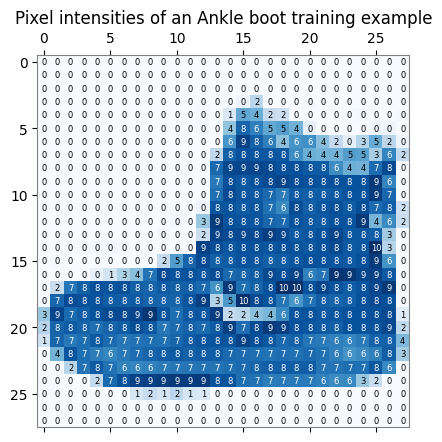

In [7]:
## Plotting a single input

exampleToShow = 0

plt.figure(figsize=(12,12))
# plt.matshow(tr_i[0], cmap=plt.cm.binary)
plt.matshow(tr_i[exampleToShow], cmap=plt.cm.Blues)

for i in range(tr_i.shape[1]):
    for j in range(tr_i.shape[2]):
        c = int((10*tr_i[exampleToShow,j,i])/255)
        plt.text(i, j, str(c), va='center', ha='center',fontsize=6,color='w' if c>5 else 'k')

exampleLabel = labels[tr_o[exampleToShow]]
plt.title(f"Pixel intensities of a{'n' if exampleLabel[0] in 'AEIOU' else ''} {exampleLabel} training example")

Class 1 has 6000 examples (10.0 %).
Class 2 has 6000 examples (10.0 %).
Class 3 has 6000 examples (10.0 %).
Class 4 has 6000 examples (10.0 %).
Class 5 has 6000 examples (10.0 %).
Class 6 has 6000 examples (10.0 %).
Class 7 has 6000 examples (10.0 %).
Class 8 has 6000 examples (10.0 %).
Class 9 has 6000 examples (10.0 %).
Class 10 has 6000 examples (10.0 %).


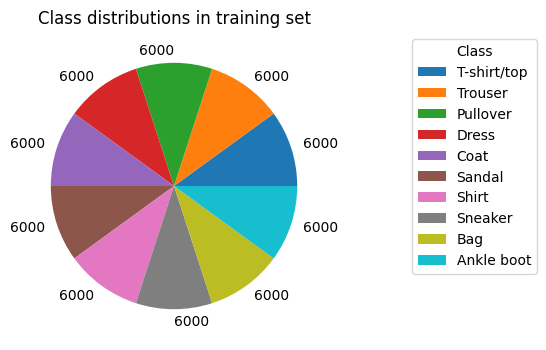

In [8]:
## Lets show the number of examples per class

plt.figure(figsize=(6,4))
nExamples = np.zeros((nClasses,),dtype='int')

useBars = False

for i in range(nClasses):
  nExamples[i] = np.sum(tr_o==i)
  print(f'Class {i+1} has {nExamples[i]} examples ({(100.0*nExamples[i])/tr_o.shape[0]} %).')
  if useBars:
    plt.bar(i+1,nExamples)

if useBars:
  plt.ylabel("# class examples")
  plt.xlabel("Class")
  plt.xticks(range(1,nClasses+1))
else:
  plt.pie(nExamples,labels=nExamples)
  
plt.legend(labels, title ="Class", bbox_to_anchor = [1.2,0,0.5,1])
plt.title("Class distributions in training set")
plt.show()

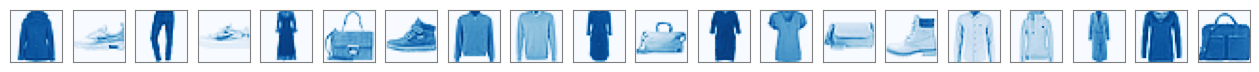

In [9]:
startExAt = 2000
nImages = 20

plt.figure(figsize=(16,2))
for i in range(startExAt,nImages+startExAt):
    plt.subplot(1,nImages,i+1-startExAt)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(tr_i[i], cmap=plt.cm.Blues)
    # plt.xlabel(f"{labels[tr_o[i]]} ({tr_o[i]})")
plt.show()


--
#### Pre-processing dataset

In [10]:
# Preparing data

norm_tr_i = tr_i/255.0
norm_val_i = val_i/255.0

oh_tr_o = tf.keras.utils.to_categorical(tr_o,num_classes=nClasses)
oh_val_o = tf.keras.utils.to_categorical(tr_o,num_classes=nClasses)

newSize = 32
tr_rs = [cv2.resize(x,(newSize,newSize)) for x in norm_tr_i]
tr_rs = np.array(tr_rs)

val_rs = [cv2.resize(x,(newSize,newSize)) for x in norm_val_i]
val_rs = np.array(val_rs)


-------------------------------------
## Modelling
-------------------------------------
The following section tests several network implementations in order to maximize the accuracy of the classification.
Starting with a basic model to set up a base accuracy, following steps evaluate:
- different convolutional architectures*
- dropout
- batch normalization
- data-augmentation
- learning-rate modulation

(*) Based on the works proposed by:
- [Kayed et al. (2020)](https://doi.org/10.1109/ITCE48509.2020.9047776)
- [Steffens et al. (2021)](https://comum.rcaap.pt/bitstream/10400.26/37237/1/ASTESJ_0601109.pdf)
- [Nocentini et al. (2022)](https://doi.org/10.3390/s22239544)

--
#### Utility functions for plotting model performance

In [11]:
## evaluateModel returns a list with each class evaluation
#  In this notebook it will return [loss,accuracy]
def evaluateModel(model,inputs=norm_val_i,gtrouth=val_o,classes=classes):
  evals = np.zeros((len(classes),2))
  for c in classes:
    evals[c] = model.evaluate(inputs[gtrouth==c],val_o[val_o==c])

  return evals

## plotMissClass creates a plot with miss classified items
def plotMissClass(model,inputs=norm_val_i,outputs=val_o,images=val_i):
  yhat = tf.argmax(tf.nn.softmax(model.predict(inputs)), 1)
  missclass = np.where(yhat != outputs)[0]
  plt.figure(figsize=(6,6))
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[missclass[i]] , cmap=plt.cm.Blues)
    plt.xlabel(f"{labels[yhat[missclass[i]]]} / {labels[outputs[missclass[i]]] } ")
  plt.show()


  confusion_matrix(outputs, yhat , normalize='pred')

## plotSingleEval plots a model metric per epoch
def plotSingleEval(history, param, addLegend = False):
  plt.plot(history[param])
  plt.plot(history['val_'+param])
  plt.ylabel(param.capitalize(),fontweight='bold')
  plt.xlabel('Epoch',fontweight='bold')
  if addLegend:
    plt.legend(['train', 'test'], loc='upper left')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

## addEvalPerClass plots (as bars) evaluations per class
def addEvalPerClass(evals,col=0):
  cxlim = plt.xlim()
  for i in range(evals.shape[0]):
    plt.bar(i,evals[i,col],fill=False,edgecolor=colors[i],alpha=0.6,linestyle=':')
  plt.ylim([min(evals[:,col])-0.05,max(evals[:,col])+0.05])

## plotModelHistory plots accuracy and loss for a given model history
def plotModelHistory(modelHist, evals = None, modelName='', addTitle=False):
  plt.figure(figsize=(4,3))
  if addTitle:
    plt.suptitle('Model evaluation'+(' using a '+modelName if modelName else ''))
  plt.subplot(2,1,1)
  plotSingleEval(modelHist.history,param='accuracy')
  if not (evals is None):
    addEvalPerClass(evals,1)
  plt.subplot(2,1,2)
  plotSingleEval(modelHist.history,param='loss',addLegend=True)
  if not(evals is None):
    addEvalPerClass(evals,0)
  plt.legend(['Training','Test']+labels, loc='center left',bbox_to_anchor = [1.2,0.6,0.5,1])
  plt.show()


--
#### Base performance using a single fully connected layer

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4969 - accuracy: 0.8255 - val_loss: 0.4303 - val_accuracy: 0.8486
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3754 - accuracy: 0.8638 - val_loss: 0.3943 - val_accuracy: 0.8590
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3363 - accuracy: 0.8775 - val_loss: 0.3699 - val_accuracy: 0.8690
Epoch 4/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.3128 - accuracy: 0.8857 - val_loss: 0.3934 - val_accuracy: 0.8613
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2936 - accuracy: 0.8920 - val_loss: 0.3378 - val_accuracy: 0.8805
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2808 - accuracy: 0.8955 - val_loss: 0.3588 - val_accuracy: 0.8716
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2676 - accuracy: 0.8996 - val_loss: 0.3515 - val_accuracy:

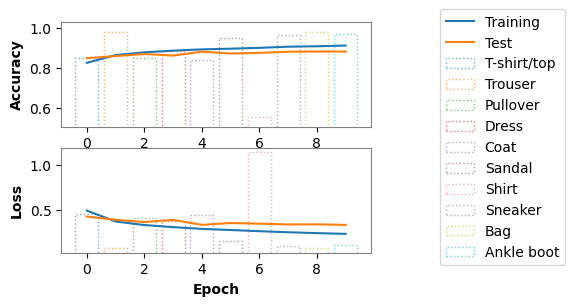

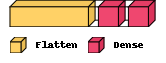

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
it = time()
sm_hist = model.fit(norm_tr_i, tr_o, epochs=10,validation_data=(norm_val_i,val_o))
print(f'Time: {time()-it:.2f}')
model.summary()
plotModelHistory(sm_hist,evaluateModel(model))
visualkeras.layered_view(model,legend=True)

--
#### Testing different CNN architectures

Also evaluating data-augmentation, dropout, and max or average pooling.


--

Testing the proposed CNN model in [tensor flow tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

Achieves there in 5 epochs 56% of accuracy. Here, it achieves 88%.

Epoch 1/10
1875/1875 [==============================] - 10s 4ms/step - loss: 0.5824 - accuracy: 0.7860 - val_loss: 0.4826 - val_accuracy: 0.8299
Epoch 2/10
1875/1875 [==============================] - 8s 5ms/step - loss: 0.4097 - accuracy: 0.8503 - val_loss: 0.4137 - val_accuracy: 0.8480
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3629 - accuracy: 0.8654 - val_loss: 0.3826 - val_accuracy: 0.8596
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3298 - accuracy: 0.8776 - val_loss: 0.3672 - val_accuracy: 0.8665
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3074 - accuracy: 0.8863 - val_loss: 0.3686 - val_accuracy: 0.8623
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2877 - accuracy: 0.8923 - val_loss: 0.3707 - val_accuracy: 0.8700
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2710 - accuracy: 0.8987 - val_loss: 0.3742 - val_accurac

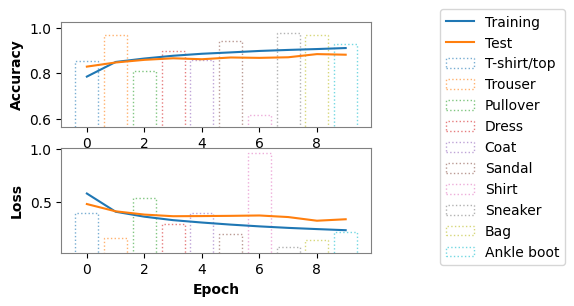

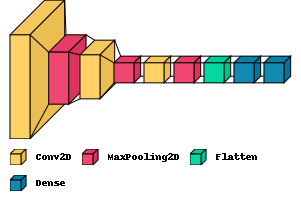

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', input_shape=(tr_i.shape[2], tr_i.shape[2], 1)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(nClasses)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
it = time()
mhist = model.fit(norm_tr_i,tr_o,validation_data=(norm_val_i,val_o),epochs=10)
model.summary()
print(f'Time: {time()-it:.2f}')
plotModelHistory(mhist,evaluateModel(model))
visualkeras.layered_view(model,legend=True)

According to [Kayed et al. (2020)](https://doi.org/10.1109/ITCE48509.2020.9047776) the LeNet-5 architecture, a widely used network for image processing, can achieve 98% of accuracy. They use 32x32 images and a CNN with average pooling.

Here:
- loss: 0.2363 
- accuracy: 0.9104 
- val_loss: 0.3730 
- val_accuracy: 0.8789

Epoch 1/10
1875/1875 [==============================] - 10s 4ms/step - loss: 0.5165 - accuracy: 0.8055 - val_loss: 0.3884 - val_accuracy: 0.8590
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3521 - accuracy: 0.8688 - val_loss: 0.3665 - val_accuracy: 0.8666
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3139 - accuracy: 0.8836 - val_loss: 0.3440 - val_accuracy: 0.8726
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2953 - accuracy: 0.8898 - val_loss: 0.3354 - val_accuracy: 0.8777
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2816 - accuracy: 0.8959 - val_loss: 0.3072 - val_accuracy: 0.8908
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2703 - accuracy: 0.8996 - val_loss: 0.3206 - val_accuracy: 0.8854
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2577 - accuracy: 0.9033 - val_loss: 0.3453 - val_accurac

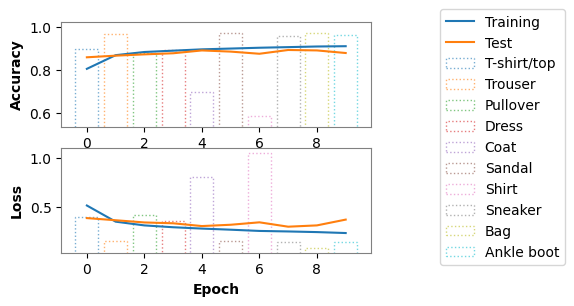

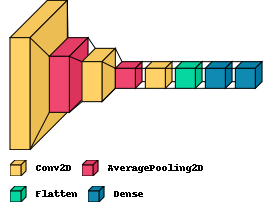

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(6, kernel_size=(5,5), activation='relu', input_shape=(newSize, newSize, 1),name='CNN1'),
    tf.keras.layers.AveragePooling2D((2,2)),
    tf.keras.layers.Conv2D(16, kernel_size=(5,5), activation='relu',name='CNN2'),
    tf.keras.layers.AveragePooling2D((2,2),strides=2),
    tf.keras.layers.Conv2D(120, kernel_size=(5,5), activation='relu',name='CNN3'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.Dense(10)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

it = time()
hist = model.fit(tr_rs,tr_o,validation_data=(val_rs,val_o),epochs=10,batch_size=32)
model.summary()
print(f'Time: {time()-it:.2f}')
plotModelHistory(hist,evaluateModel(model,inputs=val_rs))
visualkeras.layered_view(model,legend=True)


The work from [Alisson Steffens et al.](https://comum.rcaap.pt/bitstream/10400.26/37237/1/ASTESJ_0601109.pdf) describes 3 tested CNN architectures achieving 98.9% of accuracy. They use 32x32 images, adadelta as optimizer and a CNN with average pooling.

Here best results achieved were:
- loss: 0.2363 
- accuracy: 0.9104 
- val_loss: 0.3730 
- val_accuracy: 0.8789

Epoch 1/10
469/469 [==============================] - 4s 5ms/step - loss: 0.6603 - accuracy: 0.7564 - val_loss: 0.4633 - val_accuracy: 0.8251
Epoch 2/10
469/469 [==============================] - 2s 4ms/step - loss: 0.4351 - accuracy: 0.8428 - val_loss: 0.3774 - val_accuracy: 0.8623
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3813 - accuracy: 0.8612 - val_loss: 0.3641 - val_accuracy: 0.8675
Epoch 4/10
469/469 [==============================] - 3s 6ms/step - loss: 0.3520 - accuracy: 0.8720 - val_loss: 0.3304 - val_accuracy: 0.8800
Epoch 5/10
469/469 [==============================] - 2s 5ms/step - loss: 0.3313 - accuracy: 0.8796 - val_loss: 0.3111 - val_accuracy: 0.8859
Epoch 6/10
469/469 [==============================] - 2s 5ms/step - loss: 0.3179 - accuracy: 0.8824 - val_loss: 0.3051 - val_accuracy: 0.8882
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3028 - accuracy: 0.8897 - val_loss: 0.2961 - val_accuracy: 0.8926
Epoch 

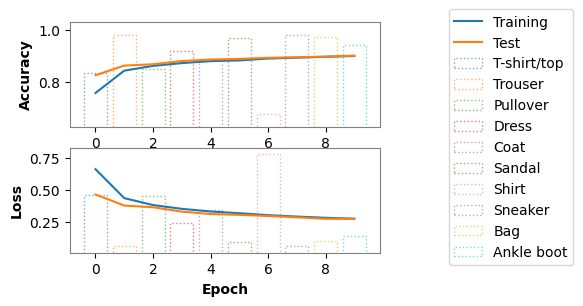

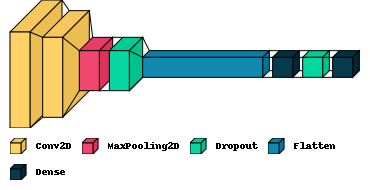

In [ ]:
## Steffens et al.
# CNN-simple
# alpha = 1

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(6, kernel_size=(5,5), activation='relu', input_shape=(tr_i.shape[2], tr_i.shape[2], 1)),
    tf.keras.layers.Conv2D(12, kernel_size=(5,5), activation='relu'),
    tf.keras.layers.MaxPooling2D(strides=2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(90, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(10)
])

model.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=1),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


it = time()
mhist = model.fit(norm_tr_i, tr_o, epochs=10,batch_size=128,validation_data=(norm_val_i,val_o))
print(f'Time: {time()-it:.2f}')
model.summary()
plotModelHistory(mhist,evaluateModel(model))
visualkeras.layered_view(model, legend=True)

Epoch 1/30
468/468 [==============================] - 21s 43ms/step - loss: 0.5645 - accuracy: 0.7886 - val_loss: 0.3045 - val_accuracy: 0.8896
Epoch 2/30
468/468 [==============================] - 17s 37ms/step - loss: 0.5027 - accuracy: 0.8105 - val_loss: 0.3049 - val_accuracy: 0.8859
Epoch 3/30
468/468 [==============================] - 18s 39ms/step - loss: 0.4770 - accuracy: 0.8208 - val_loss: 0.3123 - val_accuracy: 0.8845
Epoch 4/30
468/468 [==============================] - 17s 37ms/step - loss: 0.4615 - accuracy: 0.8278 - val_loss: 0.3067 - val_accuracy: 0.8866
Epoch 5/30
468/468 [==============================] - 19s 41ms/step - loss: 0.4505 - accuracy: 0.8325 - val_loss: 0.3063 - val_accuracy: 0.8873
Epoch 6/30
468/468 [==============================] - 21s 44ms/step - loss: 0.4421 - accuracy: 0.8348 - val_loss: 0.2990 - val_accuracy: 0.8906
Epoch 7/30
468/468 [==============================] - 22s 47ms/step - loss: 0.4334 - accuracy: 0.8382 - val_loss: 0.3054 - val_accuracy:

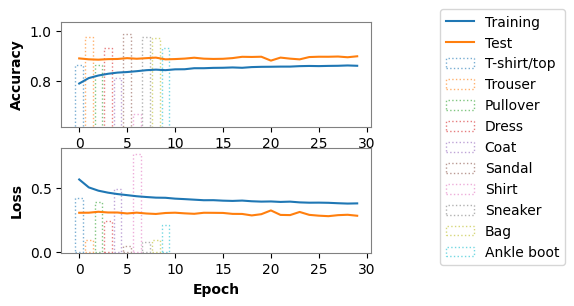

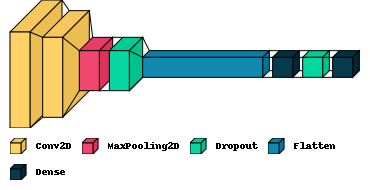

In [ ]:
## Steffens et al.
# CNN-simple with data-augmentation
# alpha = 1


# Generating more training data:
aug = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10, 
                                    width_shift_range=0.1, 
                                    height_shift_range=0.1,
                                    zoom_range=0.1)

# fit the training data
aug_tr_i = norm_tr_i.reshape(tr_i.shape[0], 28, 28, 1)
aug.fit(aug_tr_i)

it = time()
mhist = model.fit(aug.flow(aug_tr_i, tr_o, batch_size=128),epochs=30,steps_per_epoch=tr_i.shape[0]/128,validation_data=(norm_val_i,val_o))
print(f'Time: {time()-it:.2f}')
model.summary()
plotModelHistory(mhist,evaluateModel(model))
visualkeras.layered_view(model, legend=True)

Epoch 1/30
468/468 [==============================] - 22s 38ms/step - loss: 0.8668 - accuracy: 0.6736 - val_loss: 0.5324 - val_accuracy: 0.7908 - lr: 10.0000
Epoch 2/30
468/468 [==============================] - 18s 38ms/step - loss: 0.6275 - accuracy: 0.7569 - val_loss: 0.5628 - val_accuracy: 0.7922 - lr: 10.0000
Epoch 3/30
468/468 [==============================] - 17s 36ms/step - loss: 0.5947 - accuracy: 0.7728 - val_loss: 0.4558 - val_accuracy: 0.8210 - lr: 10.0000
Epoch 4/30
468/468 [==============================] - 18s 38ms/step - loss: 0.5961 - accuracy: 0.7792 - val_loss: 0.4310 - val_accuracy: 0.8383 - lr: 10.0000
Epoch 5/30
468/468 [==============================] - 18s 37ms/step - loss: 0.5586 - accuracy: 0.7863 - val_loss: 0.4589 - val_accuracy: 0.8237 - lr: 10.0000
Epoch 6/30
468/468 [==============================] - 18s 37ms/step - loss: 0.5558 - accuracy: 0.7872 - val_loss: 0.4260 - val_accuracy: 0.8379 - lr: 10.0000
Epoch 7/30
468/468 [==============================] 

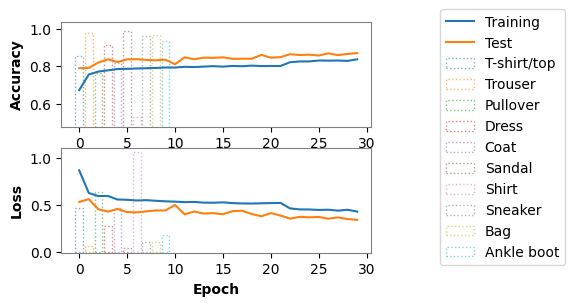

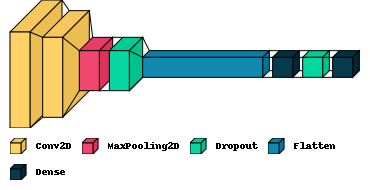

In [ ]:
## Steffens et al.
# CNN-simple with data-augmentation, learning rate annealer on plateau
# alpha = 10

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(6, kernel_size=(5,5), activation='relu', input_shape=(tr_i.shape[2], tr_i.shape[2], 1)),
    tf.keras.layers.Conv2D(12, kernel_size=(5,5), activation='relu'),
    tf.keras.layers.MaxPooling2D(strides=2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(90, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(10)
])

# Generating more training data:
aug = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10, 
                                    width_shift_range=0.1, 
                                    height_shift_range=0.1,
                                    zoom_range=0.1)

# fit the training data
aug_tr_i = norm_tr_i.reshape(tr_i.shape[0], 28, 28, 1)
aug_val_i = norm_val_i.reshape(val_i.shape[0], 28, 28, 1)
aug.fit(aug_tr_i)

model.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=10.0),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Set a learning rate annealer
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', 
                                patience=3, 
                                verbose=1, 
                                factor=0.2, 
                                min_lr=1e-6)

it = time()
mhist = model.fit(aug.flow(aug_tr_i, tr_o, batch_size=128),epochs=30,steps_per_epoch=tr_i.shape[0]/128,validation_data=(aug_val_i,val_o),callbacks=[reduce_lr])
print(f'Time: {time()-it:.2f}')
model.summary()
plotModelHistory(mhist,evaluateModel(model,inputs=aug_val_i))
visualkeras.layered_view(model, legend=True)

Epoch 1/12
469/469 [==============================] - 9s 8ms/step - loss: 0.9320 - accuracy: 0.6476 - val_loss: 0.6651 - val_accuracy: 0.7390
Epoch 2/12
469/469 [==============================] - 3s 6ms/step - loss: 0.6160 - accuracy: 0.7653 - val_loss: 0.5018 - val_accuracy: 0.7995
Epoch 3/12
469/469 [==============================] - 3s 6ms/step - loss: 0.5552 - accuracy: 0.7911 - val_loss: 0.5050 - val_accuracy: 0.8000
Epoch 4/12
469/469 [==============================] - 3s 7ms/step - loss: 0.5208 - accuracy: 0.8052 - val_loss: 0.4579 - val_accuracy: 0.8199
Epoch 5/12
469/469 [==============================] - 5s 10ms/step - loss: 0.4992 - accuracy: 0.8132 - val_loss: 0.4637 - val_accuracy: 0.8167
Epoch 6/12
469/469 [==============================] - 4s 8ms/step - loss: 0.4801 - accuracy: 0.8222 - val_loss: 0.4138 - val_accuracy: 0.8428
Epoch 7/12
469/469 [==============================] - 3s 6ms/step - loss: 0.4689 - accuracy: 0.8251 - val_loss: 0.3979 - val_accuracy: 0.8464
Epoch

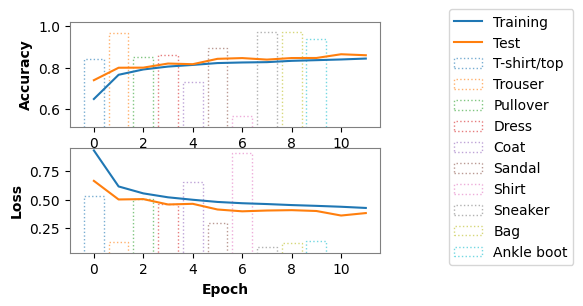

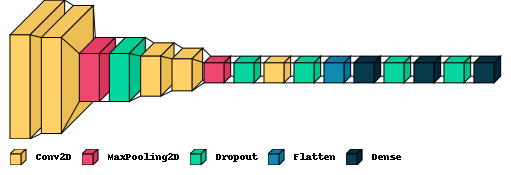

In [ ]:
## Steffens et al.
# cnn-dropout-2
# learning-rate = 3

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(6, kernel_size=(3,3), activation='relu', input_shape=(tr_i.shape[2], tr_i.shape[2], 1)),
    tf.keras.layers.Conv2D(6, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(strides=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(12, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.Conv2D(12, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(strides=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(10)
])

model.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=3.0),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

it = time()
mhist = model.fit(norm_tr_i, tr_o, epochs=12,validation_data=(norm_val_i,val_o),batch_size=128)
print(f'Time: {time()-it:.2f}')
model.summary()
plotModelHistory(mhist,evaluateModel(model))
visualkeras.layered_view(model, legend=True)

Epoch 1/12
469/469 [==============================] - 4s 5ms/step - loss: 0.8433 - accuracy: 0.6859 - val_loss: 0.5207 - val_accuracy: 0.8019
Epoch 2/12
469/469 [==============================] - 2s 4ms/step - loss: 0.5911 - accuracy: 0.7798 - val_loss: 0.4825 - val_accuracy: 0.8236
Epoch 3/12
469/469 [==============================] - 2s 5ms/step - loss: 0.5422 - accuracy: 0.7990 - val_loss: 0.4373 - val_accuracy: 0.8351
Epoch 4/12
469/469 [==============================] - 3s 6ms/step - loss: 0.5139 - accuracy: 0.8144 - val_loss: 0.4117 - val_accuracy: 0.8505
Epoch 5/12
469/469 [==============================] - 2s 4ms/step - loss: 0.4946 - accuracy: 0.8203 - val_loss: 0.4036 - val_accuracy: 0.8534
Epoch 6/12
469/469 [==============================] - 2s 4ms/step - loss: 0.4840 - accuracy: 0.8266 - val_loss: 0.3913 - val_accuracy: 0.8598
Epoch 7/12
469/469 [==============================] - 2s 5ms/step - loss: 0.4752 - accuracy: 0.8292 - val_loss: 0.3816 - val_accuracy: 0.8608
Epoch 

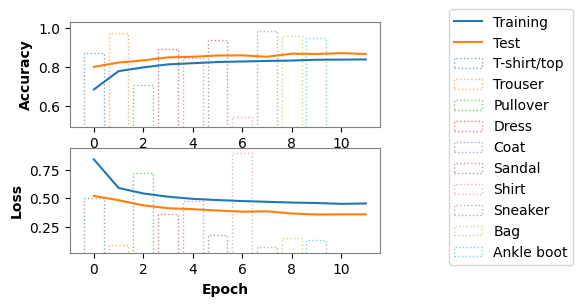

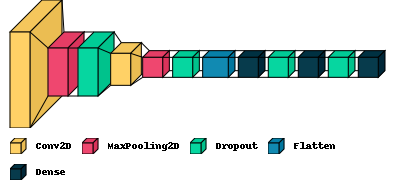

In [ ]:
## Steffens et al.
# cnn-dropout-1 and cnn-dropout-3
# learning-rate = 3

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(6, kernel_size=(5,5), activation='relu', input_shape=(tr_i.shape[2], tr_i.shape[2], 1)),
    tf.keras.layers.MaxPooling2D(strides=2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(16, kernel_size=(5,5), activation='relu'),
    tf.keras.layers.MaxPooling2D(strides=2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10)
])

model.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

it = time()
mhist = model.fit(norm_tr_i, tr_o, epochs=12,batch_size=128,validation_data=(norm_val_i,val_o))
print(f'Time: {time()-it:.2f}')
model.summary()
plotModelHistory(mhist,evaluateModel(model))
visualkeras.layered_view(model,legend=True)

In [13]:
class CosineAnnealingScheduler(tf.keras.callbacks.Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, T_max, eta_max, eta_min=0, verbose=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = tf.keras.backend.get_value(self.model.optimizer.lr)

--
#### Final CNN architecture

Based in [Olivia Nocentini et al. (2022)](https://doi.org/10.3390/s22239544).

Epoch 1/12
938/938 [==============================] - 53s 44ms/step - loss: 0.6193 - accuracy: 0.7855 - val_loss: 0.5054 - val_accuracy: 0.8298 - lr: 2.2120e-04
Epoch 2/12
938/938 [==============================] - 40s 43ms/step - loss: 0.3831 - accuracy: 0.8607 - val_loss: 0.3735 - val_accuracy: 0.8655 - lr: 2.1579e-04
Epoch 3/12
938/938 [==============================] - 40s 43ms/step - loss: 0.3166 - accuracy: 0.8859 - val_loss: 0.3276 - val_accuracy: 0.8820 - lr: 2.0008e-04
Epoch 4/12
938/938 [==============================] - 42s 44ms/step - loss: 0.2789 - accuracy: 0.8986 - val_loss: 0.3833 - val_accuracy: 0.8632 - lr: 1.7561e-04
Epoch 5/12
938/938 [==============================] - 42s 45ms/step - loss: 0.2453 - accuracy: 0.9117 - val_loss: 0.3007 - val_accuracy: 0.8956 - lr: 1.4478e-04
Epoch 6/12
938/938 [==============================] - 40s 43ms/step - loss: 0.2091 - accuracy: 0.9245 - val_loss: 0.2550 - val_accuracy: 0.9089 - lr: 1.1060e-04
Epoch 7/12
938/938 [==============

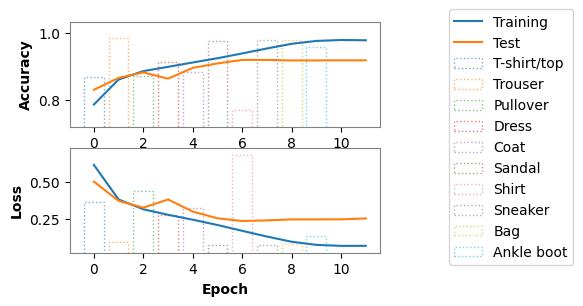

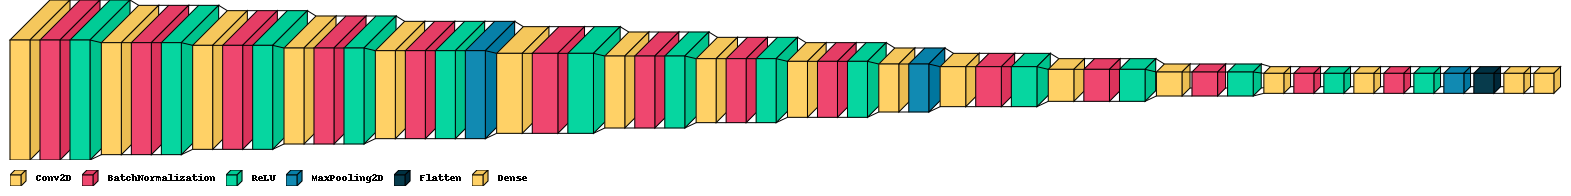

In [ ]:
##  Image Classification Using Multiple Convolutional Neural Networks on the Fashion-MNIST Dataset 2022
##  by Olivia Nocentini, Jaeseok Kim, Muhammad Zain Bashir, Filippo Cavallo

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), input_shape=(tr_rs.shape[2], tr_rs.shape[2], 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(32, kernel_size=(3,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same',strides=(1, 1)),
    tf.keras.layers.Conv2D(256, kernel_size=(3,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(192, kernel_size=(3,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(128, kernel_size=(3,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(32, kernel_size=(3,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same',strides=(1, 1)),
    tf.keras.layers.Conv2D(256, kernel_size=(3,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(256, kernel_size=(3,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(256, kernel_size=(3,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(128, kernel_size=(3,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(32, kernel_size=(3,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same',strides=(1, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10)
])
LR = 0.00022120212030797058
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

cbacks = CosineAnnealingScheduler(T_max=10, eta_max=LR, eta_min=0)

it = time()
mhist = model.fit(tr_rs, tr_o, epochs=12,batch_size=64,validation_data=(val_rs,val_o),callbacks=cbacks)
print(f'Time: {time()-it:.2f}')
model.summary()
plotModelHistory(mhist,evaluateModel(model,inputs=val_rs))
visualkeras.layered_view(model,legend=True)

Epoch 1/50
937/937 [==============================] - 54s 47ms/step - loss: 0.7330 - accuracy: 0.7444 - val_loss: 0.5352 - val_accuracy: 0.8075 - lr: 2.2120e-04
Epoch 2/50
937/937 [==============================] - 43s 46ms/step - loss: 0.4620 - accuracy: 0.8331 - val_loss: 0.3842 - val_accuracy: 0.8634 - lr: 2.1579e-04
Epoch 3/50
937/937 [==============================] - 43s 46ms/step - loss: 0.3969 - accuracy: 0.8565 - val_loss: 0.3465 - val_accuracy: 0.8750 - lr: 2.0008e-04
Epoch 4/50
937/937 [==============================] - 44s 47ms/step - loss: 0.3571 - accuracy: 0.8698 - val_loss: 0.3387 - val_accuracy: 0.8763 - lr: 1.7561e-04
Epoch 5/50
937/937 [==============================] - 43s 46ms/step - loss: 0.3237 - accuracy: 0.8835 - val_loss: 0.3069 - val_accuracy: 0.8880 - lr: 1.4478e-04
Epoch 6/50
937/937 [==============================] - 44s 47ms/step - loss: 0.2966 - accuracy: 0.8925 - val_loss: 0.3022 - val_accuracy: 0.8906 - lr: 1.1060e-04
Epoch 7/50
937/937 [==============

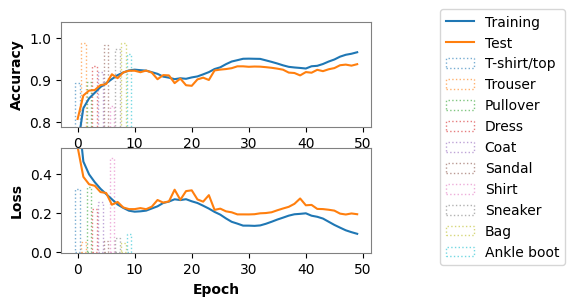

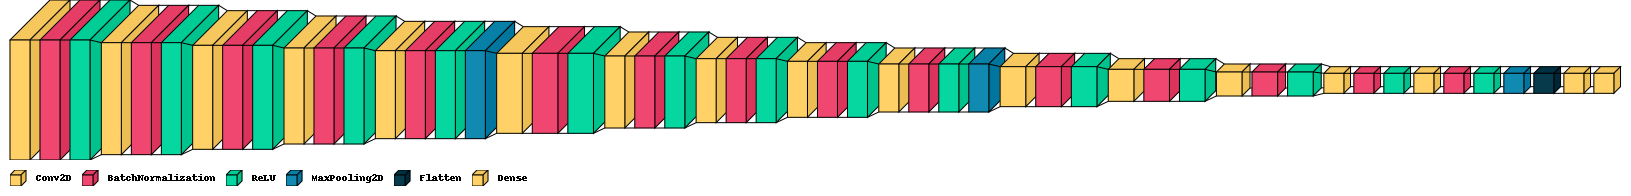

In [15]:
##  Image Classification Using Multiple Convolutional Neural Networks on the Fashion-MNIST Dataset 2022
##  by Olivia Nocentini, Jaeseok Kim, Muhammad Zain Bashir, Filippo Cavallo
#   https://doi.org/10.3390/s22239544
#
#   Using data-augmentation


model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), input_shape=(tr_rs.shape[1], tr_rs.shape[2], 1),name='CNN_1-1'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3),name='CNN_1-2'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3),name='CNN_1-3'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(32, kernel_size=(3,3),name='CNN_1-4'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3),name='CNN_1-5'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same',strides=(1, 1)),
    tf.keras.layers.Conv2D(256, kernel_size=(3,3),name='CNN_2-1'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(192, kernel_size=(3,3),name='CNN_2-2'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(128, kernel_size=(3,3),name='CNN_2-3'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3),name='CNN_2-4'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(32, kernel_size=(3,3),name='CNN_2-5'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same',strides=(1, 1)),
    tf.keras.layers.Conv2D(256, kernel_size=(3,3),name='CNN_3-1'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(256, kernel_size=(3,3),name='CNN_3-2'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(256, kernel_size=(3,3),name='CNN_3-3'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(128, kernel_size=(3,3),name='CNN_3-4'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(32, kernel_size=(3,3),name='CNN_3-5'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same',strides=(1, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10)
])
LR = 0.00022120212030797058
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

cbacks = CosineAnnealingScheduler(T_max=10, eta_max=LR, eta_min=0)

# Generating more training data:
aug = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.05, 
                                    height_shift_range=0.05,
                                    horizontal_flip=True,
                                    zoom_range=0.1) #rotation_range=10

# fit the training data
aug_tr_i = tr_rs.reshape(tr_rs.shape[0], tr_rs.shape[1], tr_rs.shape[2], 1)
aug_val_i = val_rs.reshape(val_rs.shape[0], val_rs.shape[1], val_rs.shape[2], 1)
aug.fit(aug_tr_i)

it = time()
mhist = model.fit(aug.flow(aug_tr_i, tr_o, batch_size=64),epochs=50,steps_per_epoch=tr_i.shape[0]/64,validation_data=(aug_val_i,val_o),callbacks=cbacks)
print(f'Time: {time()-it:.2f}')
model.summary()
plotModelHistory(mhist,evaluateModel(model,inputs=aug_val_i))
visualkeras.layered_view(model,legend=True)

313/313 [==============================] - 2s 7ms/step


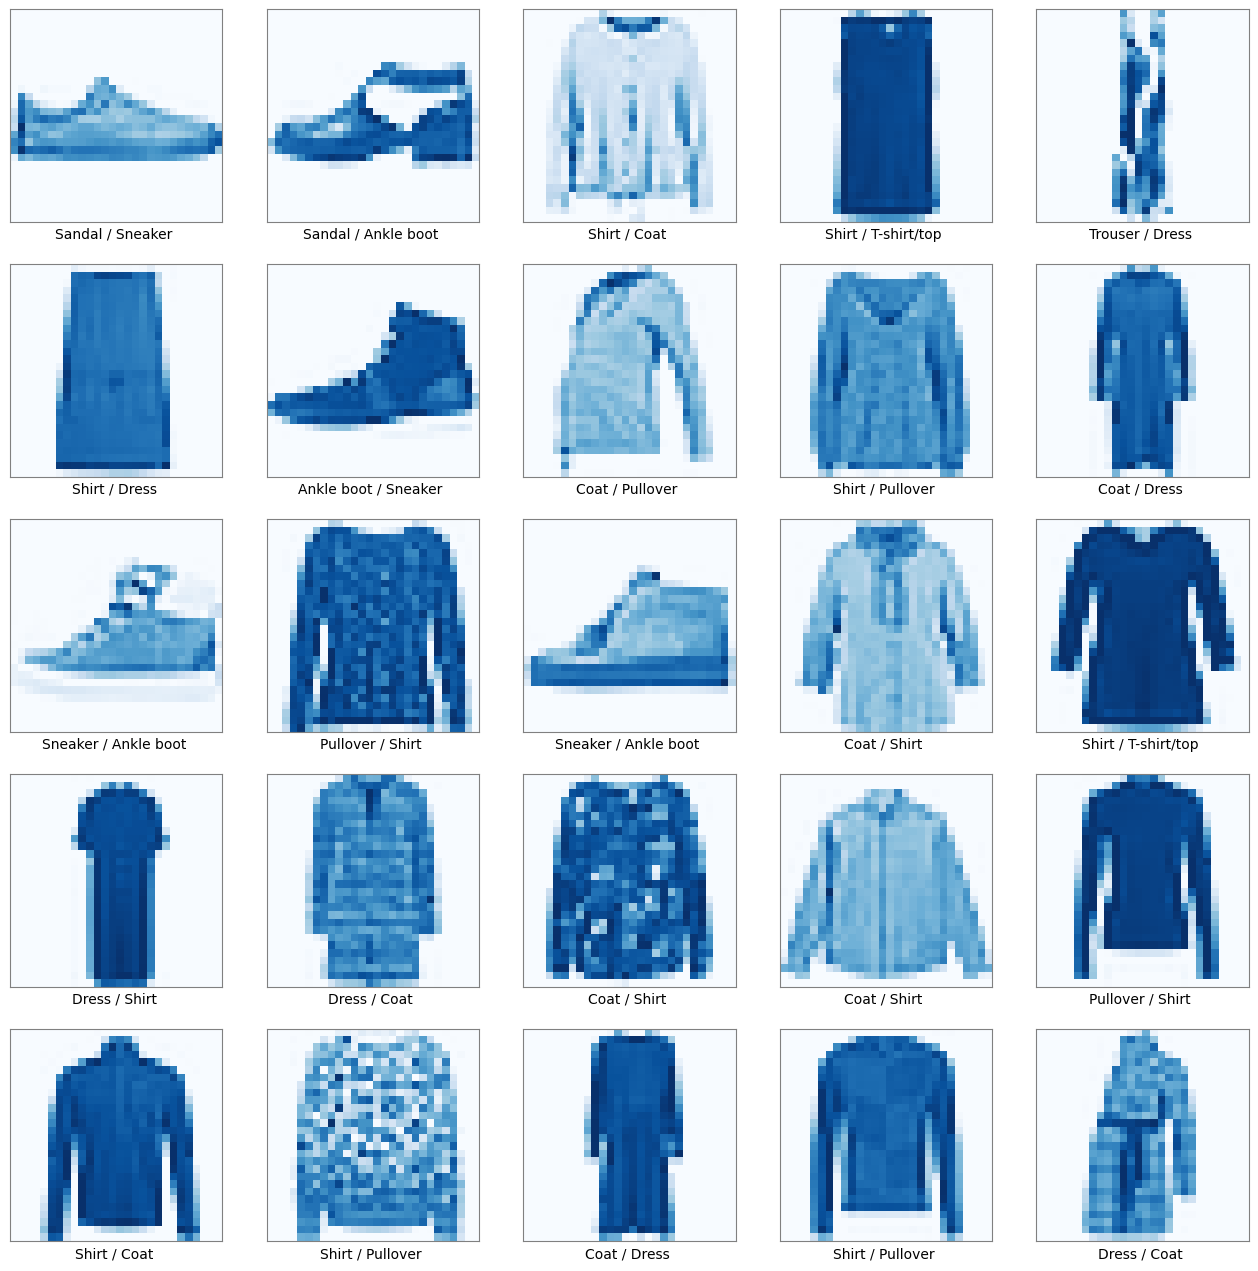

In [ ]:
plotMissClass(model,inputs=aug_val_i)

In [ ]:
##  Image Classification Using Multiple Convolutional Neural Networks on the Fashion-MNIST Dataset 2022
##  by Olivia Nocentini, Jaeseok Kim, Muhammad Zain Bashir, Filippo Cavallo
#   https://doi.org/10.3390/s22239544
#
#   Using data-augmentation with random eraser

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
  # code from https://github.com/yu4u/cutout-random-erasing
    def eraser(input_img):
        if input_img.ndim == 3:
            img_h, img_w, img_c = input_img.shape
        elif input_img.ndim == 2:
            img_h, img_w = input_img.shape

        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            if input_img.ndim == 3:
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
            if input_img.ndim == 2:
                c = np.random.uniform(v_l, v_h, (h, w))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w] = c

        return input_img

    return 


model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), input_shape=(tr_rs.shape[1], tr_rs.shape[2], 1),name='CNN_1-1'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3),name='CNN_1-2'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3),name='CNN_1-3'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(32, kernel_size=(3,3),name='CNN_1-4'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3),name='CNN_1-5'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same',strides=(1, 1)),
    tf.keras.layers.Conv2D(256, kernel_size=(3,3),name='CNN_2-1'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(192, kernel_size=(3,3),name='CNN_2-2'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(128, kernel_size=(3,3),name='CNN_2-3'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3),name='CNN_2-4'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(32, kernel_size=(3,3),name='CNN_2-5'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same',strides=(1, 1)),
    tf.keras.layers.Conv2D(256, kernel_size=(3,3),name='CNN_3-1'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(256, kernel_size=(3,3),name='CNN_3-2'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(256, kernel_size=(3,3),name='CNN_3-3'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(128, kernel_size=(3,3),name='CNN_3-4'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(32, kernel_size=(3,3),name='CNN_3-5'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same',strides=(1, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10)
])
LR = 0.00022120212030797058
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

cbacks = CosineAnnealingScheduler(T_max=10, eta_max=LR, eta_min=0)

# Generating more training data:
aug = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.05, 
                                    height_shift_range=0.05,
                                    horizontal_flip=True,
                                    zoom_range=0.1,
                                    preprocessing_function=get_random_eraser(v_l=0, v_h=1)
                                    ) #rotation_range=10

# fit the training data
aug_tr_i = tr_rs.reshape(tr_rs.shape[0], tr_rs.shape[1], tr_rs.shape[2], 1)
aug_val_i = val_rs.reshape(val_rs.shape[0], val_rs.shape[1], val_rs.shape[2], 1)
aug.fit(aug_tr_i)

it = time()
mhist = model.fit(aug.flow(aug_tr_i, tr_o, batch_size=64),epochs=50,steps_per_epoch=tr_i.shape[0]/64,validation_data=(aug_val_i,val_o))#,callbacks=cbacks)
print(f'Time: {time()-it:.2f}')
model.summary()
plotModelHistory(mhist,evaluateModel(model,inputs=aug_val_i))
visualkeras.layered_view(model,legend=True)

Epoch 1/50
937/937 [==============================] - 60s 53ms/step - loss: 0.7480 - accuracy: 0.7418 - val_loss: 0.4933 - val_accuracy: 0.8243
Epoch 2/50
 48/937 [>.............................] - ETA: 37s - loss: 0.5121 - accuracy: 0.8158